<a href="https://colab.research.google.com/github/bethfisher-hub/Colour_Similartiy_90/blob/main/computational_mechanisms_of_gratitude_practice_belief_updating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import random
from google.colab import files
!pip install matplotlib
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)


def softmax(X):                                                                 ###converts log probabilities to probabilities
  norm = np.sum(np.exp(X)+10**-5)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def softmax_dim2(X):                                                            ###converts matrix of log probabilities to matrix of probabilities
  norm = np.sum(np.exp(X)+10**-5,axis=0)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def normalise_3x2(X):                                                           ###normalises a matrix of probabilities
  X = X/np.sum(X,0)
  return X

def normalise(X):                                                               ###normalises a matrix of probabilities
  X= X/np.sum(X,0)
  return X

def NormalizeData(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))


The following code sets up the agents for the gratitude practice  

In [ ]:
################################################################################
### Defining global parameters
################################################################################

T = 12                                                                          ### Number of time-steps


In [ ]:
################################################################################
### Initialising the agents's generative model
################################################################################

######## Perceptual level 1 ##########

# Perceptual state beliefs
X1 = np.zeros((2,T))                                                            ### perception prior (going well vs going poorly)
X1bar = np.zeros((2,T))                                                         ### perception posterior
X1[:,0] = [0.5,0.5]                                                             ### perceptual state prior at T=0, ie. D1

# Defining the likelihood matrix

A1 = np.zeros((3, 2))                                                           ### setting up the likelihood matrix
A1bar = np.zeros((3, 2))                                                        ###

A1[0,:] = [.7,.2]                                                               ### likelihood of observing a good outcome,
A1[1,:] = [.1,.1]                                                               ### likelihood of observing a neutral outcome,
A1[2,:] = [.2,.7]                                                               ### likelihood of observing a bad outcome


In [ ]:
################################################################################
### Running the simulation over multiple trials (i.e. days)
################################################################################

luckiness = np.array([0.1, 0.3, 0.5, 0.7, 0.9])                                 ### Luckiness of agent: range = [0,1] where 0 = no luck, 1 = all luck
days = 7

data = np.zeros((len(luckiness),days,4,T))
A_matrices = np.zeros((len(luckiness),days,3,2))
X_vectors = np.zeros((len(luckiness),days,2,1))


### Parameters required for learning
learning_rate = 2                                                                                                                                        # (this also influences how quickly the agent ceases to select information-seeking policies)"
forgetting_rate = 1


# parameters of the generative process
x1 = np.zeros(T)                                                                ### T=12 hours per day awake. x = [going well, going poorly]
b1 = np.zeros((2,2))

a1 = np.zeros((3,2))
a1[0,:] = [.7,.2]
a1[1,:] = [.1,.1]
a1[2,:] = [.2,.7]


o = np.zeros(T)
O = np.zeros((2,T))

for luck in range(len(luckiness)):

  # Hour state transitions b1 = p(x(t+1)|x(t))
  b1[:,0]=[luckiness[luck],1-luckiness[luck]]                                   ### probablity of transitioning from going well states to going badly states
  b1[:,1]=[luckiness[luck],1-luckiness[luck]]

  B1 = b1

  # reset A matrix for ea. luckiness
  A1[0,:] = [.7,.2]
  A1[1,:] = [.1,.1]
  A1[2,:] = [.2,.7]


  for day in range(days):
    # reset gen process
    x1[0] = 0                                                                   ### Day starts well
    o = np.zeros(T)
    O = np.zeros((3,T))

    # save A matrix
    A_matrices[luck,day,:,:] = A1                                               ## save the A matrix

    for t in range(T):
      # generate observation
      o[t] = np.random.choice(np.arange(3),p=a1[:,int(x1[t])])

      ### infer state
      X1bar[:,t] = softmax(np.log(X1[:,t])+np.log(A1[int(o[t]),:]))             ## calculate state posterior

      if t<(T-1):
        # evolve generative process
        x1[t+1] = np.random.choice(np.arange(2),p=b1[:,int(x1[t])])
        ###evolve expected states
        X1[:,t+1] = np.inner(B1,X1bar[:,t])                                      # first level  state prior for next timestep

    data[luck,day,0,:] = x1
    data[luck,day,1,:] = o
    data[luck,day,2,:] = X1bar[0]
    data[luck,day,3,:] = X1bar[1]


    ### Between trial learning
    # creating one-hot O matrix
    for t in range(T):
      if o[t] == 0:
        O[0,t] = 1
      elif o[t] == 1:
        O[1,t] = 1
      elif o[t] == 2:
        O[2,t] = 1

    # A1 likelihood matrix learning
    sum_of_coincidences = np.zeros((3,2))                                         ## sum coincidences of observations and inferred states
    for t in range(T):
      coincidence_t = np.outer(O[:,t],X1bar[:,t])
      sum_of_coincidences = sum_of_coincidences + coincidence_t

    A1[0,0] = forgetting_rate * A1[0,0] + learning_rate * sum_of_coincidences[0,0]
    A1[1,0] = forgetting_rate * A1[1,0] + learning_rate * sum_of_coincidences[1,0]
    A1[2,0] = forgetting_rate * A1[2,0] + learning_rate * sum_of_coincidences[2,0]
    A1[0,1] = forgetting_rate * A1[0,1] + learning_rate * sum_of_coincidences[0,1]
    A1[1,1] = forgetting_rate * A1[1,1] + learning_rate * sum_of_coincidences[1,1]
    A1[2,1] = forgetting_rate * A1[2,1] + learning_rate * sum_of_coincidences[2,1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

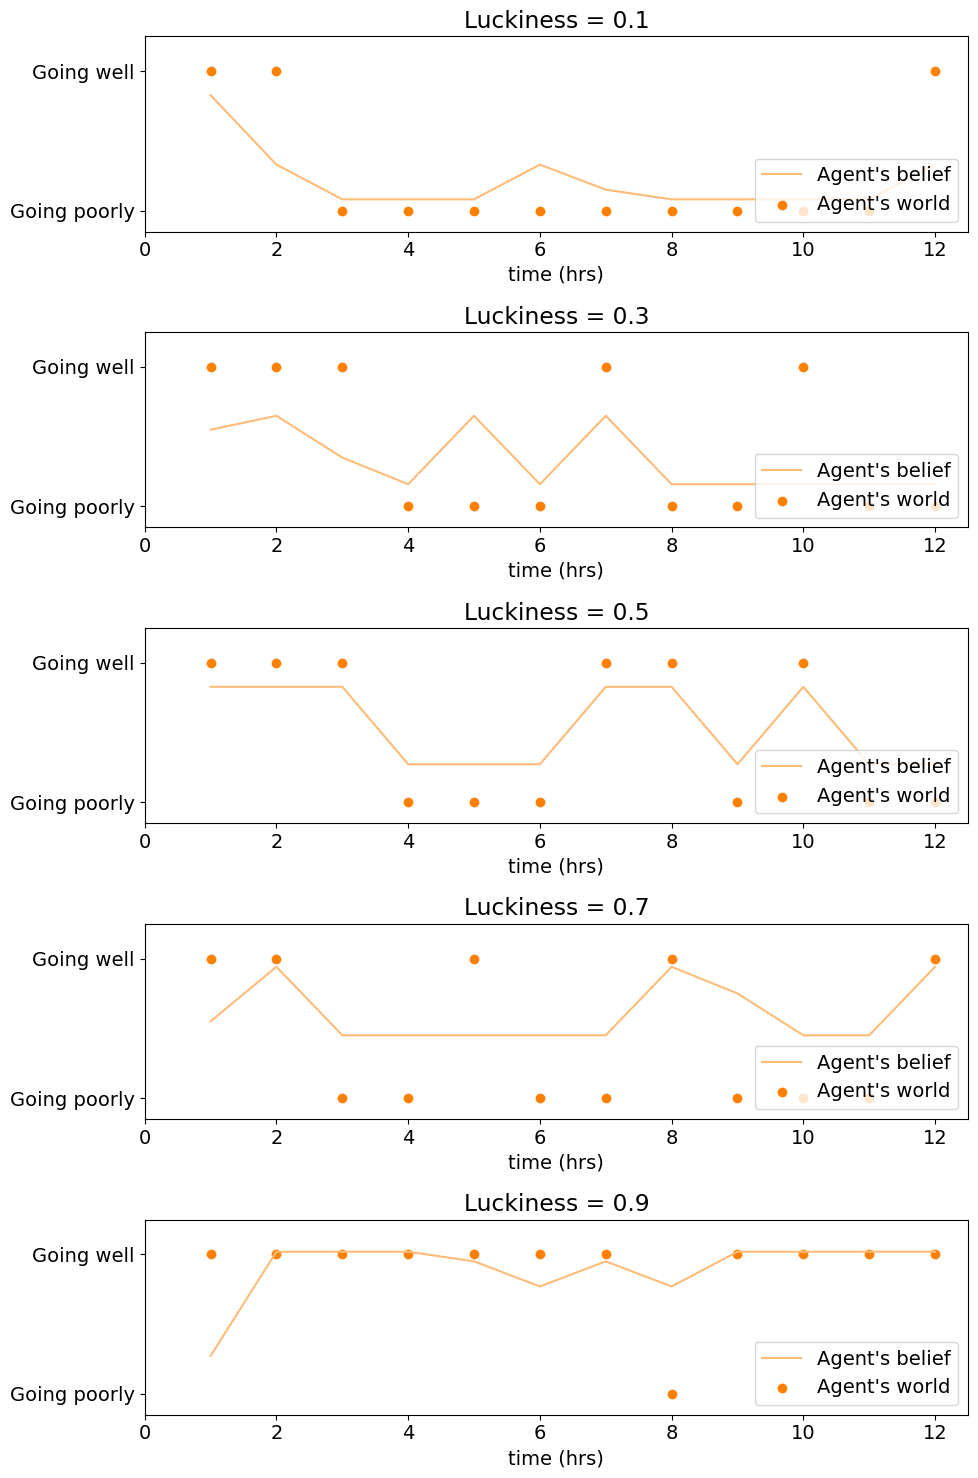

In [ ]:
################################################################################
### Plotting results

################################################################################
plt.figure(figsize=(10,15))

plt.subplot(5,1,1)
plt.plot(1+np.arange(T),data[0,0,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data[0,0,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[0,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.1')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,2)
plt.plot(1+np.arange(T),data[1,0,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data[1,0,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[1,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.3')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,3)
plt.plot(1+np.arange(T),data[2,0,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data[2,0,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[2,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.5')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,4)
plt.plot(1+np.arange(T),data[3,0,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data[3,0,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[3,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.7')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,5)
plt.plot(1+np.arange(T),data[4,0,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data[4,0,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[4,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.9')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.tight_layout()



plt.savefig("figure_2_GRAT.png", dpi = 600)
files.download("figure_2_GRAT.png")

In this section of code the agents perform a belief updating task before the gratitude intervetion. The agent's belief about the world going well or poorly is taken from the initial simulation

In [ ]:
################################################################################
### Belief updating task before gratitude intervention
################################################################################

# Time steps

T = 1;                                                                          # Each trial is one time step

B = np.zeros((2,2))
B[0,:]=[1 , 0]                                                                  # identity matrix
B[1,:]=[0 , 1]
# Generative process
b = np.zeros((2,2))
b[0,:]=[1 , 0]                                                                  # identity matrix
b[1,:]=[0 , 1]
a = np.zeros((2,2))
a[0,:]=[1 , 0]                                                                  # identity matrix
a[1,:]=[0 , 1]
# Observations
o = np.zeros(T)
data_updates= np.zeros((len(luckiness),2))
# Generate 70 random numbers for the beliefs about good and bad outcomes,
# set beliefs at this range as most similar to the list from Sharot et al.,2011
# list of 70 random numbers between 0.7 and 0.2
likelihood = [random.uniform(0.2, 0.7) for _ in range(70)]
# generate 35 0s and 35 1s in a list this sets and good news and bad news trials
zeros = [0] * 35
ones = [1] * 35
outcomes  = zeros + ones

# Run the task for each agent, set by their belief about the world
for luck in range(len(luckiness)):
    A1 = np.zeros((2,2,2))
    x2 = ((data[luck,6,2,11], data[luck,6,3,11])) # optimism bias, from X1bar
    print(x2)
    # Optimistic belief updating
    A1[0,:, 1] = [0.8, 0.2] # good outcome
    A1[1,:, 1] = [0.4, 0.6] # bad outcome
    # Pesmisitc belief updating
    A1[0,:, 0] = [0.6, 0.4] # good outcome
    A1[1,:, 0] = [0.2, 0.8] # bad outcome
    good_updates_for_luck = []  # Store good updates for this luck value
    bad_updates_for_luck = []  # Store bad updates for this luck value

    for trial in range(70):
     o = [outcomes[trial], (1-outcomes[trial])]
     # generative model
     X1 = [likelihood[trial], (1-likelihood[trial])]   # prior belief about event
     X1bar = [0, 0]    # posterior belief
     ### infer state, is the agent in and optimistic or pessimsitc state based  in x2
     optimism =  np.random.choice(np.arange(2),p=x2)
     # the update to good or bad news is conditioned on the opitimism state factor
     X1bar = softmax(np.log(X1)+np.log((np.dot(A1[:,:,optimism],o))))
    # Save good news trials for the agent
     if o[0] == 1:
          trialtype = "good"
          goodupdate =  X1bar[0] - X1[0]
          good_updates_for_luck.append(goodupdate)
  # Save bad news trials for the agent
     if o[1] == 1:
          trialtype = "bad"
          badupdate = X1bar[1] - X1[1]
          bad_updates_for_luck.append(badupdate)  # Store bad update
    # Calculate and store the average update for this luck value
    if good_updates_for_luck and bad_updates_for_luck:  # Check if both lists have values
       average_update_good = np.mean(good_updates_for_luck)
       average_update_bad = np.mean(bad_updates_for_luck)
       data_updates[luck,0] =  average_update_good
       data_updates[luck,1] =  average_update_bad


(0.0048614598679503915, 0.9951385401320496)
(0.20203306598306534, 0.7979669340169347)
(0.22223456735256222, 0.7777654326474377)
(0.7871274446065426, 0.21287255539345737)
(0.9863485553308021, 0.013651444669197797)


Plot results of belief updating task

0.15743856985167423
0.1757683687019607
0.17158646181334317
0.22014424297214585
0.24165138657907984


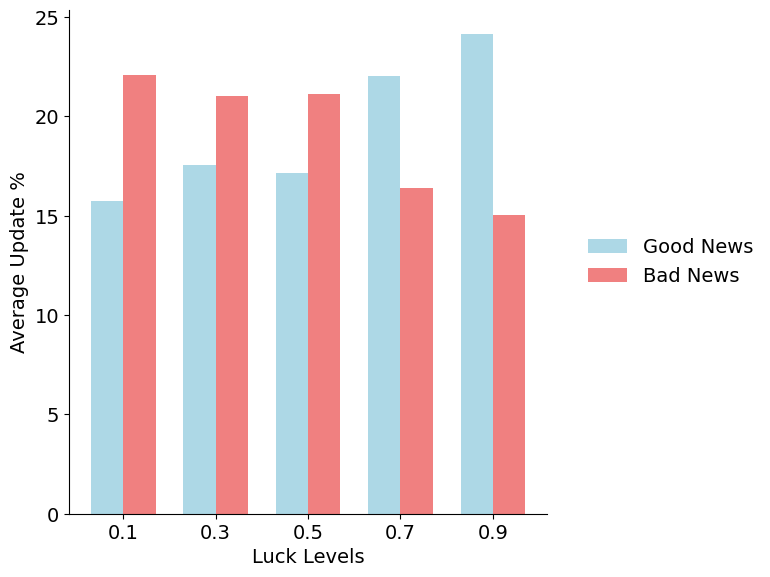

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size if needed
plt.rcParams.update({'font.size': 14})  # Adjust font size as needed


bar_width = 0.35
x = np.arange(len(luckiness))

rects1 = ax.bar(0 - bar_width/2, data_updates[0,0]*100, bar_width, color='lightblue', label='Good News' )
rects2 = ax.bar(0 + bar_width/2, data_updates[0,1]*100, bar_width, color='lightcoral', label='Bad News' )
plt.rcParams['font.family'] = 'DejaVu Sans'  # Replace 'Arial' with your desired font

for luck in range(len(luckiness)):
  print(data_updates[luck,0])
  rects1 = ax.bar(luck - bar_width/2, data_updates[luck,0]*100, bar_width, color='lightblue')
  rects2 = ax.bar(luck + bar_width/2, data_updates[luck,1]*100, bar_width, color='lightcoral')

# Add labels, title, and legend
ax.set_xlabel('Luck Levels')
ax.set_ylabel('Average Update %')
ax.set_xticks(x)
ax.set_xticklabels(luckiness)
# Move legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=14, frameon=False)



# Only show lines for y and x axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Use tight_layout to adjust subplot parameters for a tight layout
plt.tight_layout()

# Save the plot to a file with higher DPI
#plt.savefig('Beliefupdating1.png',dpi=300)


from google.colab import files
#files.download('Beliefupdating1.png')

# Display plot
plt.show()

In [ ]:
################################################################################
### Running an average day for agents who have had different weeks
################################################################################

T = 12

data_after_learning = np.zeros((len(luckiness),3,T))

a1 = np.zeros((3,2))
a1[:,0] = [.7,.2,.1]
a1[:,1] = [.1,.2,.7]

# Hour state transitions b1 = p(x(t+1)|x(t))
b1 = np.zeros((2,2))
b1[:,0]=[0.7,0.3]                                                                ### probablity of transitioning to X1(t+1) = 0 from X1(t) = 0/1
b1[:,1]=[0.3,0.7]

X1 = np.zeros((2,T))                                                            ### perception prior (going well vs going poorly)
X1bar = np.zeros((2,T))                                                         ### perception posterior
X1[:,0] = [0.5,0.5]

# generative model of transitions is same as the generative process
B1 = b1

# True state of hour
x1 = np.zeros(T)                                                                ### T=12 hours per day awake. x = [going well, going poorly]
x1[0] = 0

# Evolve true states of generative process
for t in range(T):
  if t<T-1:
    x1[t+1] = np.random.choice(np.arange(2),p=b1[:,int(x1[t])])

 # Generate outcomes based on generative process
o = np.zeros(T)
for i in range(T):                                                                ### during the inhale phase, observation is 0, 'expansion'
  o[i] = np.random.choice(np.arange(3),p=a1[:,int(x1[i])])

for luck in range(len(luckiness)):

  # reset A matrix for ea. luckiness                                              # with each new observation the agent becomes less confident in what it has previously learned)."
  A1 = A_matrices[luck,6]                                                         ### perceptual model learned over the past week

  #reset inferences
  X1[:,0] = [0.5, 0.5]                                                           ### perceptual state prior at T=0, ie. D1

  for t in range(T):
    ### State belief updating
    ### perceptual level X1
    X1bar[:,t] = softmax(np.log(X1[:,t])+np.log(A1[int(o[t]),:]))               ## calculate perceptual state posterior

    if t<(T-1):
      ###evolve expected states
      X1[:,t+1] = np.inner(B1,X1bar[:,t])                                       # first level perceptual state prior for next timestep

  data_after_learning[luck,0,:] = x1
  data_after_learning[luck,1,:] = o
  data_after_learning[luck,2,:] = X1bar[0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

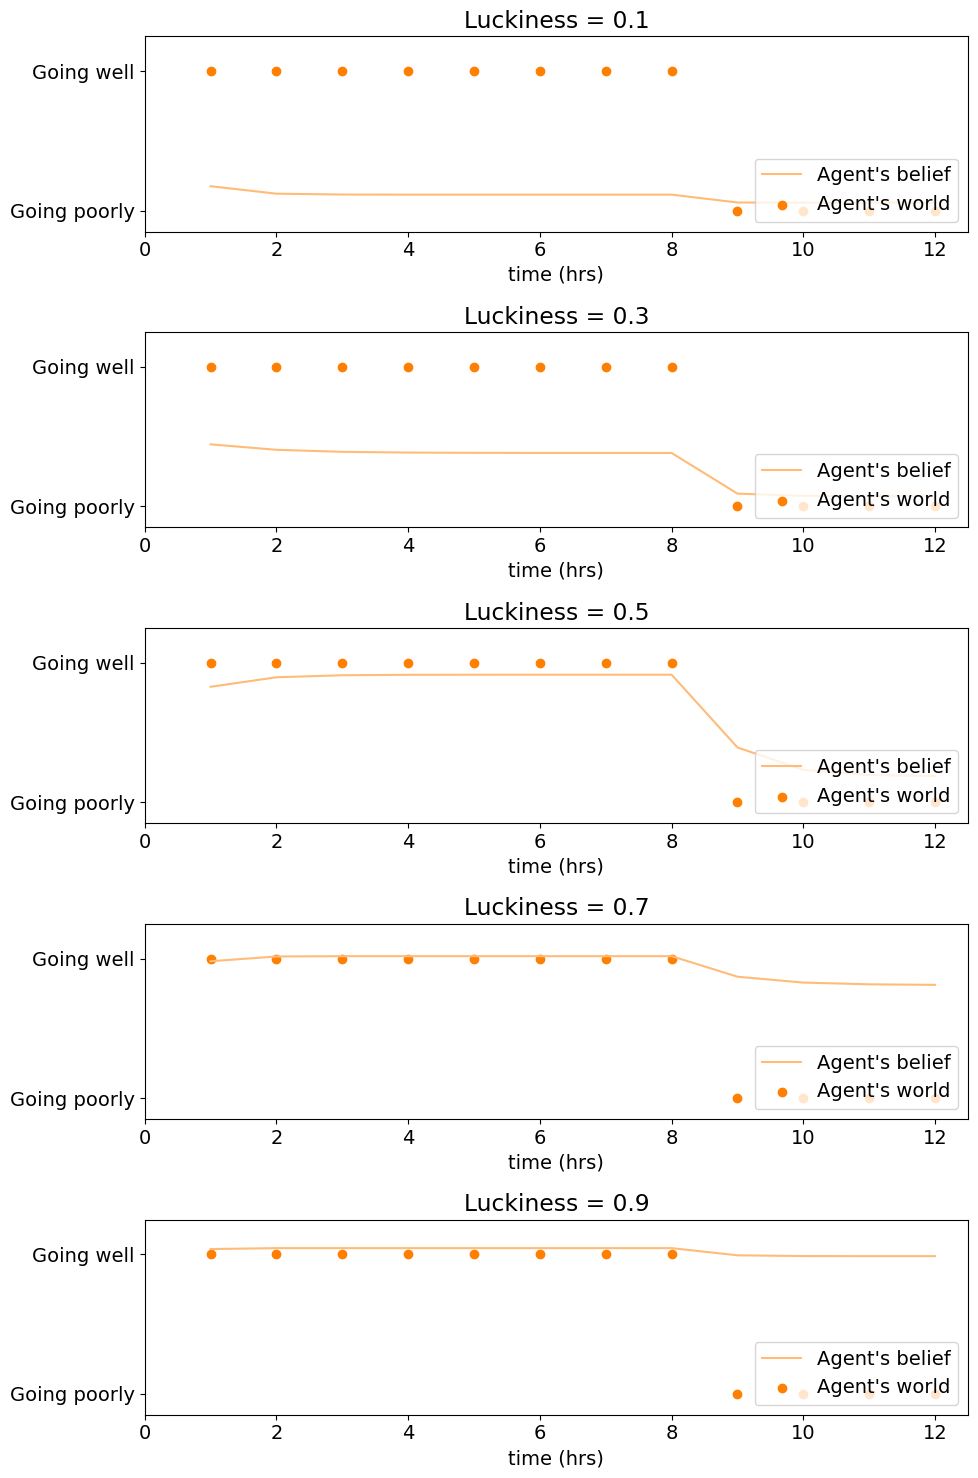

In [ ]:
################################################################################
### Plotting results

################################################################################
plt.figure(figsize=(10,15))

plt.subplot(5,1,1)
plt.plot(1+np.arange(T),data_after_learning[0,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data_after_learning[0,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[0,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.1')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,2)
plt.plot(1+np.arange(T),data_after_learning[1,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data_after_learning[1,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[1,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.3')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,3)
plt.plot(1+np.arange(T),data_after_learning[2,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data_after_learning[2,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[2,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.5')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,4)
plt.plot(1+np.arange(T),data_after_learning[3,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data_after_learning[3,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[3,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.7')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,5)
plt.plot(1+np.arange(T),data_after_learning[4,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data_after_learning[4,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[4,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.9')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.tight_layout()



plt.savefig("figure_2_beforeGRAT.png", dpi = 600)
files.download("figure_2_beforeGRAT.png")

In [ ]:
################################################################################
### Running the simulation over a week of gratitude
################################################################################

luckiness = np.array([0.1, 0.3, 0.5, 0.7, 0.9])                                   ### Luckiness of agent: range = [0,1] where 0 = no luck, 1 = god mode
days = 7
# Perceptual state beliefs
X1 = np.zeros((2,T))                                                            ### perception prior (going well vs going poorly)
X1bar = np.zeros((2,T))                                                         ### perception posterior
X1[:,0] = [0.5,0.5]
T= 12

data_gratitude = np.zeros((len(luckiness),days,4,T))
A_matrices_gratitude = np.zeros((len(luckiness),days,3,2))

# Hour state transitions b1 = p(x(t+1)|x(t))
b1 = np.zeros((2,2))
b1[:,0]=[0.7,0.3]                                                                ### probablity of transitioning to X1(t+1) = 0 from X1(t) = 0/1
b1[:,1]=[0.3,0.7]

B1 = b1

a1 = np.zeros((3,2))
a1[:,0] = [.7,.2,.1]
a1[:,1] = [.1,.2,.7]

learning_rate = 2
forgetting_rate = 1

for luck in range(len(luckiness)):
  # reset A matrix for ea. luckiness                                              # with each new observation the agent becomes less confident in what it has previously learned)."
  A1 = A_matrices[luck,6]                                                          ### likelihood of observing 01 = 0 "expansion" given X1(breath) = inhaling/exhaling

  for day in range(days):
    x1 = np.zeros(T)                                                                ### T=12 hours per day awake. x = [going well, going poorly]
    x1[0] = 0
    o = np.zeros(T)
    O = np.zeros((3,T))

    #reset inferences
    X1[:,0] = [0.5,0.5]

    # Evolve true states of generative process
    for t in range(T):
      o[t] = np.random.choice(np.arange(3),p=a1[:,int(x1[t])])
      X1bar[:,t] = softmax(np.log(X1[:,t])+np.log(A1[int(o[t]),:]))               ## calculate perceptual state posterior

      if t<T-1:
        x1[t+1] = np.random.choice(np.arange(2),p=b1[:,int(x1[t])])
        X1[:,t+1] = np.inner(B1,X1bar[:,t])                                       # first level perceptual state prior for next timestep

    ### Performing gratitude meditation at the end of the day
    count = 0
    indexes_of_positive = np.where(o==0)[0]
    indexes_of_neutrals = np.where(o==1)[0]
    index = np.concatenate([indexes_of_positive,indexes_of_neutrals])
    index = np.sort(index)

    for i in index:
      X1bar[:,i] = [1,0]
      count = count + 1
      if count == 3:
        break

    data_gratitude[luck,day,0,:] = x1
    data_gratitude[luck,day,1,:] = o
    data_gratitude[luck,day,2,:] = X1bar[0]
    data_gratitude[luck,day,3,:] = X1bar[1]


    ### Between trial learning
    # creating one-hot O matrix
    for t in range(T):
      if o[t] == 0:
        O[0,t] = 1
      elif o[t] == 1:
        O[1,t] = 1
      elif o[t] == 2:
        O[2,t] = 1

    # A1 likelihood matrix learning
    sum_of_coincidences = np.zeros((3,2))                                         ## sum coincidences of observations and inferred states
    for t in range(T):
      coincidence_t = np.outer(O[:,t],X1bar[:,t])
      sum_of_coincidences = sum_of_coincidences + coincidence_t

    A1[0,0] = forgetting_rate * A1[0,0] + learning_rate * sum_of_coincidences[0,0]
    A1[1,0] = forgetting_rate * A1[1,0] + learning_rate * sum_of_coincidences[1,0]
    A1[2,0] = forgetting_rate * A1[2,0] + learning_rate * sum_of_coincidences[2,0]
    A1[0,1] = forgetting_rate * A1[0,1] + learning_rate * sum_of_coincidences[0,1]
    A1[1,1] = forgetting_rate * A1[1,1] + learning_rate * sum_of_coincidences[1,1]
    A1[2,1] = forgetting_rate * A1[2,1] + learning_rate * sum_of_coincidences[2,1]

    # save A matrix
    A_matrices_gratitude[luck,day,:,:] = A1

In [ ]:
################################################################################
### Belief updating task after gratitude intervention
################################################################################

# Time steps

T = 1;

B = np.zeros((2,2))
B[0,:]=[1 , 0]                                                                 ### identity matrix
B[1,:]=[0 , 1]
# Generative process
b = np.zeros((2,2))
b[0,:]=[1 , 0]                                                                 ### identity matrix
b[1,:]=[0 , 1]
a = np.zeros((2,2))
a[0,:]=[1 , 0]                                                                 ### identity matrix
a[1,:]=[0 , 1]
# Observations
o = np.zeros(T)
data_updates= np.zeros((len(luckiness),2))
# Generate 70 random numbers for the beliefs about good and bad outcomes,
# set beliefs at this range as most similar to the list from Sharot et al.,2011
# list of 70 random numbers between 0.7 and 0.2
likelihood = [random.uniform(0.2, 0.7) for _ in range(70)]
# generate 35 0s and 35 1s in a list this sets and good news and bad news trials
zeros = [0] * 35
ones = [1] * 35
outcomes  = zeros + ones

# Run the task for each agent, set by luck
for luck in range(len(luckiness)):
    A1 = np.zeros((2,2,2))
    x2 = ((data_gratitude[luck,6,2,11], data_gratitude[luck,6,3,11])) # optimism bias, from X1bar
    print(x2)
    # Optimistic belief updating
    A1[0,:, 1] = [0.8, 0.2] # good outcome
    A1[1,:, 1] = [0.4, 0.6] # bad outcome
    # Pesmisitc belief updating
    A1[0,:, 0] = [0.6, 0.4] # good outcome
    A1[1,:, 0] = [0.2, 0.8] # bad outcome
    good_updates_for_luck = []  # Store good updates for this luck value
    bad_updates_for_luck = []  # Store bad updates for this luck value

    for trial in range(70):
     o = [outcomes[trial], (1-outcomes[trial])]
     # generative model
     X1 = [likelihood[trial], (1-likelihood[trial])]   # prior belief about event
     X1bar = [0, 0]    # posterior belief
     ### infer state, is the agent in and optimistic or pessimsitc state based  in x2
     optimism =  np.random.choice(np.arange(2),p=x2)
     # the update to good or bad news is conditioned on the opitimism state factor
     X1bar = softmax(np.log(X1)+np.log((np.dot(A1[:,:,optimism],o))))
    # Save good news trials for the agent
     if o[0] == 1:
          trialtype = "good"
          goodupdate =  X1bar[0] - X1[0]
          good_updates_for_luck.append(goodupdate)
  # Save bad news trials for the agent
     if o[1] == 1:
          trialtype = "bad"
          badupdate = X1bar[1] - X1[1]
          bad_updates_for_luck.append(badupdate)  # Store bad update
    # Calculate and store the average update for this luck value
    if good_updates_for_luck and bad_updates_for_luck:  # Check if both lists have values
       average_update_good = np.mean(good_updates_for_luck)
       average_update_bad = np.mean(bad_updates_for_luck)
       data_updates[luck,0] =  average_update_good
       data_updates[luck,1] =  average_update_bad


(0.25622937576055954, 0.7437706242394404)
(0.4678038493386507, 0.5321961506613493)
(0.7362383139793304, 0.2637616860206695)
(0.9849416492170042, 0.015058350782995734)
(0.9943238526330171, 0.0056761473669828776)


0.18426228566219055
0.20210932411094656
0.22439487898509947
0.2395381517509268
0.2395381517509268


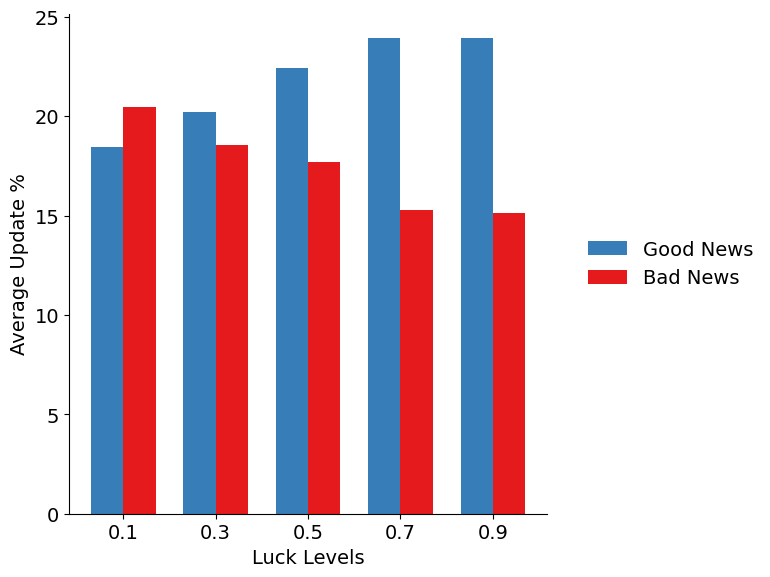

In [ ]:
# Plot belief updating task after intervention
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size if needed
plt.rcParams.update({'font.size': 14})  # Adjust font size as needed


bar_width = 0.35
x = np.arange(len(luckiness))

rects1 = ax.bar(0 - bar_width/2, data_updates[0,0]*100, bar_width, color='#377eb8', label='Good News' )
rects2 = ax.bar(0 + bar_width/2, data_updates[0,1]*100, bar_width, color='#e41a1c', label='Bad News' )
plt.rcParams['font.family'] = 'DejaVu Sans'  # Replace 'Arial' with your desired font

for luck in range(len(luckiness)):
  print(data_updates[luck,0])
  rects1 = ax.bar(luck - bar_width/2, data_updates[luck,0]*100, bar_width, color='#377eb8')
  rects2 = ax.bar(luck + bar_width/2, data_updates[luck,1]*100, bar_width, color='#e41a1c')

# Add labels, title, and legend
ax.set_xlabel('Luck Levels')
ax.set_ylabel('Average Update %')
ax.set_xticks(x)
ax.set_xticklabels(luckiness)
# Move legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=14, frameon=False)



# Only show lines for y and x axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Use tight_layout to adjust subplot parameters for a tight layout
plt.tight_layout()

# Save the plot to a file with higher DPI
#plt.savefig('Beliefupdating.png',dpi=300)


from google.colab import files
#files.download('Beliefupdating.png')

# Display plot
plt.show()

In [ ]:
################################################################################
### Running an average day for agents who have had different weeks
################################################################################

T = 12

data_averageday_gratitude = np.zeros((len(luckiness),3,T))

a1 = np.zeros((3,2))
a1[:,0] = [.7,.2,.1]
a1[:,1] = [.1,.2,.7]

# Hour state transitions b1 = p(x(t+1)|x(t))
b1 = np.zeros((2,2))
b1[:,0]=[0.7,0.3]                                                                ### probablity of transitioning to X1(t+1) = 0 from X1(t) = 0/1
b1[:,1]=[0.3,0.7]

X1 = np.zeros((2,T))                                                            ### perception prior (going well vs going poorly)
X1bar = np.zeros((2,T))                                                         ### perception posterior
X1[:,0] = [0.5,0.5]

# generative model of transitions is same as the generative process
B1 = b1

# True state of hour
x1 = np.zeros(T)                                                                ### T=12 hours per day awake. x = [going well, going poorly]
x1[0] = 0

# Evolve true states of generative process
for t in range(T):
  if t<T-1:
    x1[t+1] = np.random.choice(np.arange(2),p=b1[:,int(x1[t])])

 # Generate outcomes based on generative process
o = np.zeros(T)
for i in range(T):                                                                ### during the inhale phase, observation is 0, 'expansion'
  o[i] = np.random.choice(np.arange(3),p=a1[:,int(x1[i])])

for luck in range(len(luckiness)):

  # reset A matrix for ea. luckiness                                              # with each new observation the agent becomes less confident in what it has previously learned)."
  A1 = A_matrices_gratitude[luck,6]                                                         ### perceptual model learned over the past week
                                                        ### perceptual model learned over the past week

  #reset inferences
  X1[:,0] = [0.5, 0.5]                                                           ### perceptual state prior at T=0, ie. D1

  for t in range(T):
    ### State belief updating
    ### perceptual level X1
    X1bar[:,t] = softmax(np.log(X1[:,t])+np.log(A1[int(o[t]),:]))               ## calculate perceptual state posterior

    if t<(T-1):
      ###evolve expected states
      X1[:,t+1] = np.inner(B1,X1bar[:,t])                                       # first level perceptual state prior for next timestep

  data_averageday_gratitude[luck,0,:] = x1
  data_averageday_gratitude[luck,1,:] = o
  data_averageday_gratitude[luck,2,:] = X1bar[0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

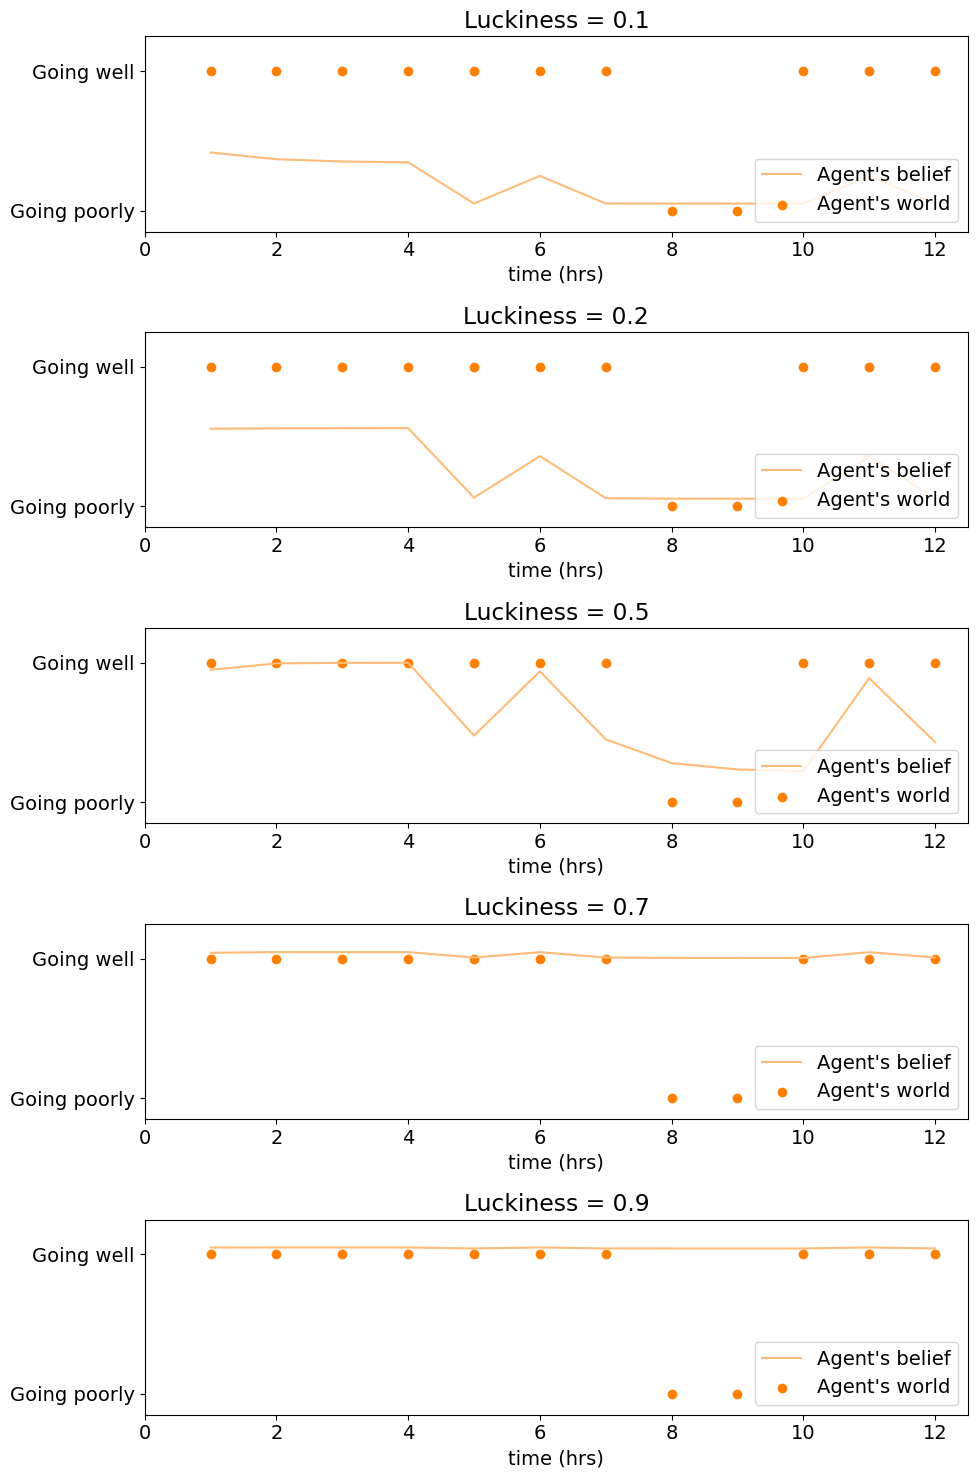

In [ ]:
################################################################################
### Plotting results

################################################################################
plt.figure(figsize=(10,15))

plt.subplot(5,1,1)
plt.plot(1+np.arange(T),data_averageday_gratitude[0,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data_averageday_gratitude[0,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[0,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.1')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,2)
plt.plot(1+np.arange(T),data_averageday_gratitude[1,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data_averageday_gratitude[1,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[0,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.2')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,3)
plt.plot(1+np.arange(T),data_averageday_gratitude[2,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data_averageday_gratitude[2,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[2,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.5')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,4)
plt.plot(1+np.arange(T),data_averageday_gratitude[3,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data_averageday_gratitude[3,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[3,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.7')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.subplot(5,1,5)
plt.plot(1+np.arange(T),data_averageday_gratitude[4,2,:],label=r"Agent's belief",color='#ffbb78')
plt.scatter(1+np.arange(T),(1-data_averageday_gratitude[4,0,:])-0.05,label="Agent's world",color='#ff7f00')
#plt.scatter(1+np.arange(T)+.1, (1-NormalizeData(data[4,0,1,:]))+0.05,label='observations',color='orange')
plt.yticks([-0.05,0.95],['Going poorly','Going well'])
plt.xlabel(r'time (hrs)')
# plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('Luckiness = 0.9')
plt.legend(loc = 'lower right')
plt.ylim([-0.2,1.2])
plt.xlim([0,T+0.5])

plt.tight_layout()



#plt.savefig("figure_2_afterGRAT.png", dpi = 600)
files.download("figure_2_afterGRAT.png")